In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch

import gym

from a2c.a2c import A2C
from a2c.callback import ProgressBarCallback

from environments.continuous_teaching import ContinuousTeaching

sns.set()

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

# Without breaks

In [34]:
env = ContinuousTeaching(t_max=100, alpha=0.2, tau=0.9)

In [4]:
model = A2C(env, seed=123)

iterations = env.t_max * 1000
check_freq = env.t_max

with ProgressBarCallback(env, check_freq) as callback:
    model.learn(iterations, callback=callback)

0it [00:00, ?it/s]

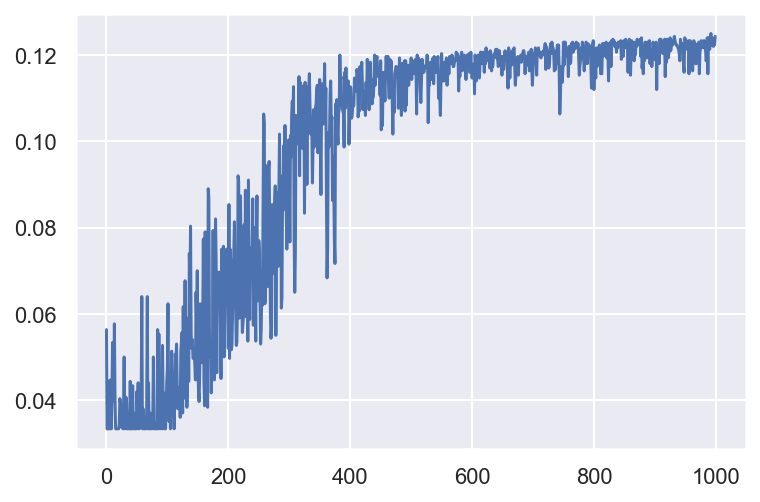

In [5]:
plt.plot([np.mean(r) for r in callback.hist_rewards])

In [7]:
rewards = []
actions = []

obs = env.reset()
while True:
    action = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    
    rewards.append(reward)
    actions.append(action)
    
    if done:
        obs = env.reset()
        break

In [8]:
env.n_item

30

In [9]:
np.sum(rewards)

12.466666666666663

In [10]:
rewards = np.array(rewards)*env.n_item

(374.0, 1.879468009836826)

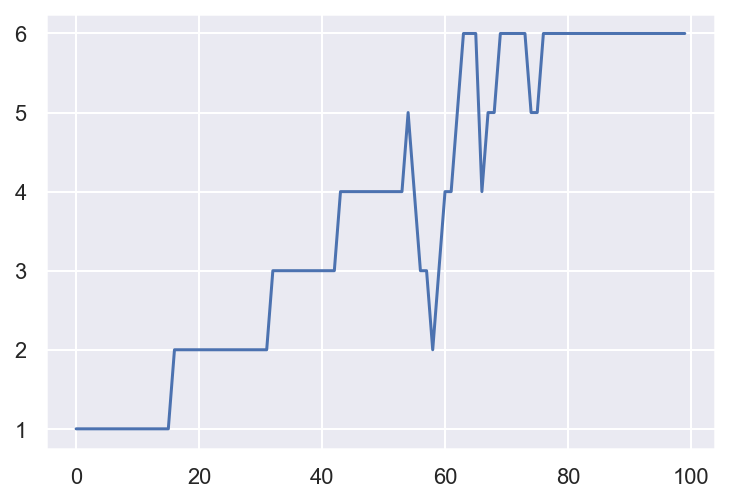

In [11]:
plt.plot(rewards)
np.sum(rewards), np.std(rewards)

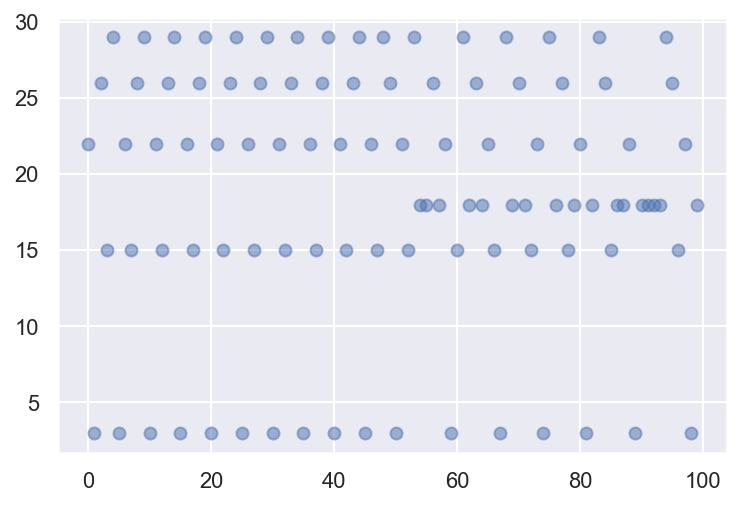

In [12]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5);

In [35]:
class Threshold:
    def __init__(self, tau, n_item):
        self.tau = tau
        self.n_item = n_item
        
    def act(self, obs):
        if obs.shape[0] % 2 == 0:
            obs = obs.reshape((obs.shape[0]//2, 2))
        else:
            obs = obs[:-1].reshape(((obs.shape[0] - 1)//2, 2))
        p_rec = obs[:, 0]

        view_under_thr = (0 < p_rec) * (p_rec <= self.tau)
        if np.count_nonzero(view_under_thr) > 0:
            items = np.arange(self.n_item)
            selec = items[view_under_thr]
            action = selec[np.argmin(p_rec[view_under_thr])]
        else:
            n_seen = np.count_nonzero(p_rec)
            max_item = self.n_item - 1
            action = np.min((n_seen, max_item))

        return action

In [36]:
obs = env.reset()
policy = Threshold(tau=0.9, n_item=env.n_item)
rewards = []
actions = []
while True:
    action = policy.act(obs)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

In [37]:
rewards = np.array(rewards)*env.n_item

(360.0, 1.7492855684535902)

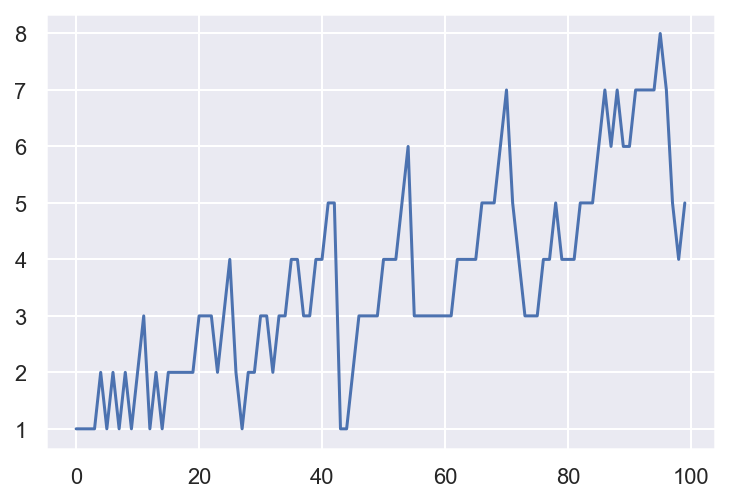

In [38]:
plt.plot(rewards)
np.sum(rewards), np.std(rewards)

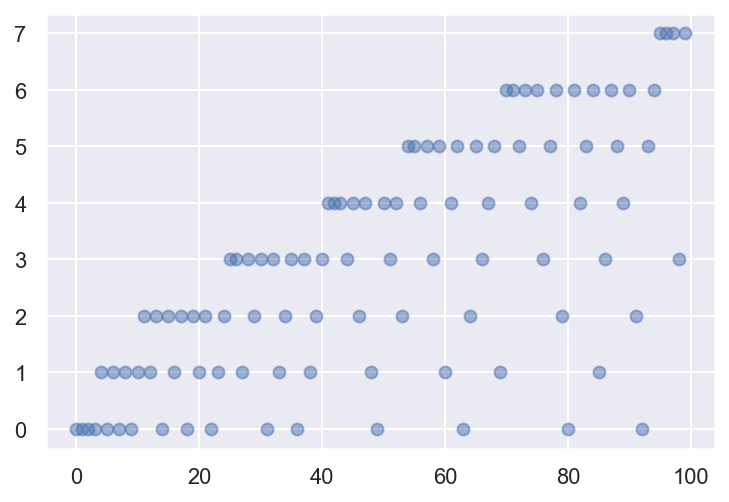

In [39]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5);

# With breaks

In [40]:
class DiscontinuousTeaching(gym.Env):

    def __init__(self, alpha=1., beta=0.2, tau=0.9, n_item=30, t_max=1000, n_break=10, break_length=10):
        super().__init__()

        self.action_space = gym.spaces.Discrete(n_item)
        self.observation_space = gym.spaces.Box(low=0.0, high=np.inf,
                                                shape=(n_item*2 + 1, ))
        self.state = np.zeros((n_item, 2))
        self.obs = np.zeros((n_item, 2))
        self.n_item = n_item
        self.t_max = t_max
        self.t = 0

        self.log_tau = np.log(tau)
        self.alpha = alpha
        self.beta = beta
        
        self.schedule = np.ones(t_max)
        self.breaks = np.zeros(n_break, dtype=int)
        self.breaks[:] = np.round(np.arange(0, t_max, t_max/(n_break+1))[1:])
        self.schedule[self.breaks] = break_length

    def reset(self):
        self.state = np.zeros((self.n_item, 2))
        self.obs = np.zeros((self.n_item, 2))
        self.t = 0
        return self.format_obs()
    
    def format_obs(self):
        return np.hstack((self.obs.flatten(), np.array([self.session_progression(), ])))
    
    def session_progression(self):
        remaining = np.min(self.breaks - self.t)
        scaled_remaining = remaining / self.breaks[0]
        progress = 1. - scaled_remaining
        return progress

    def step(self, action):
        time_delta = self.schedule[self.t]
        self.state[:, 0] += time_delta  # increase delta for all items
        self.state[action, 0] = 0  # ...except for item shown
        self.state[action, 1] += 1  # increment number of presentation

        done = self.t == self.t_max - 1

        view = self.state[:, 1] > 0
        delta = self.state[view, 0]
        rep = self.state[view, 1] - 1.

        forget_rate = self.alpha * (1 - self.beta) ** rep

        logp_recall = - forget_rate * delta
        above_thr = logp_recall > self.log_tau
        reward = np.count_nonzero(above_thr) / self.n_item

        self.obs[view, 0] = np.exp(-forget_rate * (delta + 1))
        self.obs[view, 1] = forget_rate

        info = {}
        self.t += 1
        return self.format_obs(), reward, done, info

In [41]:
env = DiscontinuousTeaching(t_max=100, alpha=0.2, beta=0.1, tau=0.9, n_break=5, break_length=1000)

In [42]:
obs = env.reset()
policy = Threshold(tau=0.9, n_item=env.n_item)
rewards = []
actions = []
while True:
    action = policy.act(obs)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

In [43]:
rewards = np.array(rewards)*env.n_item

(232.0, 1.085172797300043)

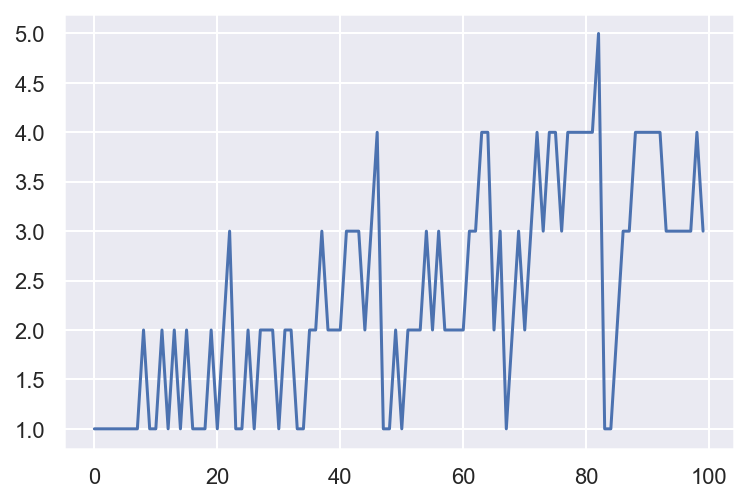

In [44]:
plt.plot(rewards)
np.sum(rewards), np.std(rewards)

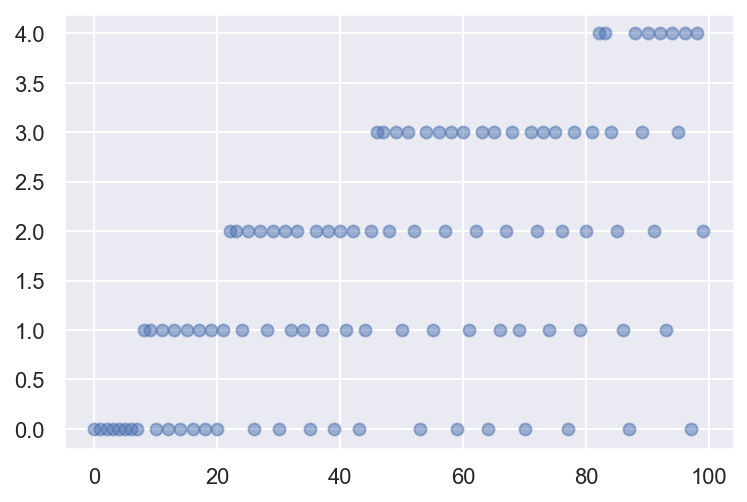

In [45]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5);

In [ ]:
model = A2C(env, seed=123)

iterations = env.t_max * 10000
check_freq = env.t_max

with ProgressBarCallback(env, check_freq) as callback:
    model.learn(iterations, callback=callback)

0it [00:00, ?it/s]

In [ ]:
plt.plot([np.mean(r) for r in callback.hist_rewards])

In [ ]:
rewards = []
actions = []

obs = env.reset()
while True:
    action = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    
    rewards.append(reward)
    actions.append(action)
    
    if done:
        obs = env.reset()
        break

In [ ]:
env.n_item

In [ ]:
np.sum(rewards)

In [ ]:
rewards = np.array(rewards)*env.n_item

In [ ]:
plt.plot(rewards)
np.sum(rewards), np.std(rewards)

In [ ]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5);